In [93]:
import torch, pickle, sys
sys.path.append('/home/dgotzens/scripts')
import pdfdefaults as pdf
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
from math import sin,cos,sqrt,log10
pi = 3.141592653589 
maxdist = 50
c0 = 299_792_458 
f0, f1 = 76_009_996_288.0, 80_289_505_280.0
omega0, omega1 = 2*pi*f0, 2*pi*f1

t_chirp = 0.000_064_890_002_249_740_060
fs = 22e6
Ts=1/fs
M,K = 1022,192

omegadot = (omega1-omega0)/t_chirp

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))

vx,vy = params['vxPosX'], params['vxPosX']
X = max(vx)
ch_window = torch.tensor([sin(pi*x/X)**2 for x in vx])

settings = {'channel gain':     torch.ones(K),
# settings = {'channel gain':     ch_window/ch_window.sum(),
            'chirp slope':      (f1-f0)/t_chirp,
            'start frequency':  f0,
            'sample period':    Ts,
            'lightspeed':       c0,
            'y_tx' :            params['txPosY'],
            'x_tx' :            params['txPosX'],
            'y_rx' :            params['rxPosY'],
            'x_rx' :            params['rxPosX']}
  
def calc_image_hybrid(data, settings, pos):
    M,K = data.shape
    PP = pos.shape[:-1]

    gain = settings['channel gain']                     # P1xP2x...Pn x K
    slope = settings['chirp slope']
    f0 = settings['start frequency']
    c0 = settings['lightspeed']
    Ts = settings['sample period']
    N = settings['fftlen']
    maxdist = c0/Ts / (4*slope)
    
    fft = torch.fft.fft(data, n=N, dim=0)             
    tau = time_of_flight(settings, pos)                 # P1xP2x...Pn x K
    weights = gain * torch.exp(1j*omega0*tau)         # P1xP2x...Pn x K
    m_refl = (c0*tau/2 * N/maxdist).round().int()       # P1xP2x...Pn x K


    fft_flat = fft.flatten(0,-2)
    img = torch.zeros(PP, dtype=torch.cfloat)
    for k in range(K):
        m_refl_flat = m_refl.flatten(0,-2)[:,k]
        fft_sel = fft_flat[m_refl_flat,k]
        weights_flat = weights.flatten(0,-2)[:,k]
        img +=  (weights_flat.conj()*fft_sel).unflatten(0,PP)
    
    return img

def time_of_flight(settings, pos):
    x_tx, x_rx = settings['x_tx'], settings['x_rx']
    y_tx, y_rx = settings['y_tx'], settings['y_rx']
    K=len(x_tx)
    c0 = settings['lightspeed']

    txpos = torch.tensor([x_tx,y_tx,[0]*K]).transpose(0,1)
    rxpos = torch.tensor([x_rx,y_rx,[0]*K]).transpose(0,1)
    # K x 3                   
    pos = pos.unsqueeze(-2)
    # PP x 1 x 3   
    r_tx = (txpos-pos).square().sum(-1).sqrt()  
    r_rx = (rxpos-pos).square().sum(-1).sqrt()
    # sum(PPx1x3 - Kx3, -1) = PPxK
    return (r_tx+r_rx)/c0  

dBr = lambda x: 20*(x/x.abs().max()).log10()


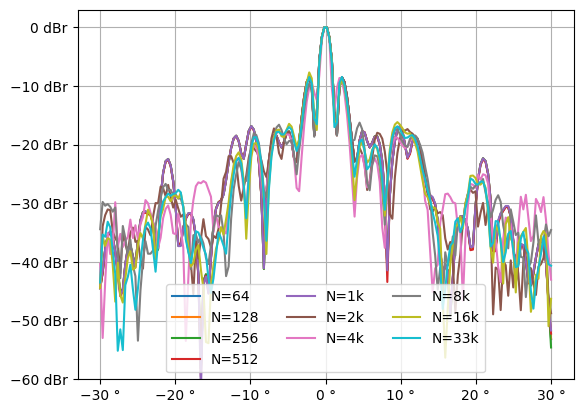

In [115]:
fftlens = [2**n for n in range(6,16,1)]
dist = 3
target_pos = torch.tensor([0,0,dist]) 
tau = time_of_flight(settings,target_pos) 
data = torch.exp(1j * omegadot * tau * torch.arange(0,M)[:,None]*Ts)
data *= torch.exp(1j*omega0*tau)

settings['limits'] = (-12,12,0,0,0,15)
settings['resolution'] = (240,1,150)
settings['coordinate type'] = 'cylindrical'
Nangle = 180
angle = torch.linspace(-30,30,Nangle) * pi/180
pos = dist*torch.stack([angle.sin(), torch.zeros(Nangle), angle.cos()], -1)
tau = time_of_flight(settings, pos)                           # P1xP2x...Pn x K

to_eng = lambda x : x if x<1e3 else f'{x/1000**int(log10(x)/3):.0f}' + ' kMGT'[int(log10(x)/3)]

for N in fftlens:
    settings['fftlen'] = N
    img=calc_image_hybrid(data,settings,pos)
    plt.plot(angle*180/pi, dBr(img.abs()), label=f'N={to_eng(N)}')
    # plt.plot(dBr(img.abs()), label=f'N={to_eng(N)}')
plt.legend(ncols=3)
plt.gca().xaxis.set_major_formatter(EngFormatter('°'))
plt.gca().yaxis.set_major_formatter(EngFormatter('dBr'))
plt.grid()
plt.ylim(-60,3)
plt.savefig('/home/dgotzens/thesis/figures/hybrid_azm_peak.pdf')
plt.show()
plt.show()


In [6]:
# 5, 20, 25,
# dists = torch.tensor([0.1,0.5,1,5,10])
dists = torch.tensor([.3,.5,1,2,5,10,15,25,40])
# dists = torch.linspace(0.1,5,11)
D=len(dists)
target_pos = torch.stack([torch.zeros(D),torch.zeros(D),dists], -1)
tau = time_of_flight(settings,target_pos).T ## KxD

data = torch.exp(1j * omegadot * tau * torch.arange(M)[:,None,None]*Ts)*torch.exp(1j*omega0*tau)
print(data.shape)

torch.Size([1022, 192, 9])


In [7]:
N = 90
angle = torch.linspace(-90,90,N) * pi/180
pos = dists[:,None,None] * torch.stack([torch.zeros(N), angle.sin(), angle.cos()], -1)
imgs = calc_image_bp(data,settings,pos)


torch.Size([9, 90, 1022, 192])


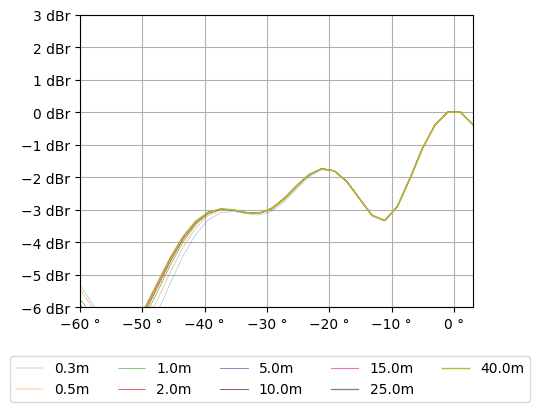

In [26]:
fig, ax = plt.subplots(1)
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for d,dist in enumerate(dists):
    # ax.plot(angle*180/pi, imgs[d,:,d].abs(), label=f'{dist:.1f}m', linewidth=1)
    ax.plot(angle*180/pi, dBr(imgs[d,:,d].abs()), label=f'{dist:.1f}m', linewidth=0.2+d*0.1)
fig.set_figwidth(0.7*pdf.a4_textwidth)
ax.xaxis.set_major_formatter(EngFormatter('°'))
ax.yaxis.set_major_formatter(EngFormatter('dBr'))
ax.set_ylim(-6,3)
ax.set_xlim(-60,3)
# ax.set_yticks(torch.linspace(-20,10/3,8), minor=True)
# ax.set_yticks(range(-20,1,10), minor=False)
# ax.set_xticks(torch.linspace(-90,90,19), minor=True)
# ax.set_xticks(torch.linspace(-90,90,7), minor=False)
ax.grid(which='major')
# ax.grid(linestyle=':', which='minor')
fig.legend(*ax.get_legend_handles_labels(), bbox_to_anchor=(0.5,0), loc='upper center', ncols=5)
fig.set_size_inches(0.8*pdf.a4_textwidth, 0.6*pdf.a4_textwidth)
# fig.savefig('/home/dgotzens/thesis/figures/bp_elv_peak.pdf')
